In [2]:
import os
import time
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform

from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from datasets import *
from utils import *
from nltk.translate.bleu_score import corpus_bleu

from scipy.misc import imread, imresize
from PIL import Image

# sets device for model and PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Task
![title](notebook_images/task.png)

# Training data
![title](notebook_images/coco_image.png)

### Captioning challenge was part of the Large-scale Scene Understanding (LSUN) CVPR 2015 workshop organized by Princeton University.

![title](notebook_images/training_data.png)

# Encoder

### ResNet101 as encoder
![title](notebook_images/encoder.png)

### Feature maps
![title](notebook_images/feature_maps.gif)

In [3]:
class Encoder(nn.Module):
    """
    Encoder model
    """
    
    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size
        
        # pretrained ImageNet ResNet-101
        resnet = torchvision.models.resnet101()
        resnet.load_state_dict(torch.load('models/resnet101-5d3b4d8f.pth'))

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=False):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.

        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False

        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

# Additive Attention

![title](notebook_images/additive_attention.jpeg)
![title](notebook_images/attention_dim.png)

# Context Vector
![title](notebook_images/context_vector.png)

In [5]:
class Attention(nn.Module):
    """
    Attention Network
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()

        # linear layer to transform encoded image 2048, 512
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)

        # linear layer to transform decoder's output 512 to 512
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)

        # linear layer to calculate values to be softmax-ed
        self.full_att = nn.Linear(attention_dim, 1)

        # relu activation function
        self.relu = nn.ReLU()
        
        # softmax layer to calculate weights
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        # (batch_size, num_pixels, attention_dim)
        # (batch_size, 196, 512)
        att1 = self.encoder_att(encoder_out)
        
        # (batch_size, 512)
        att2 = self.decoder_att(decoder_hidden)
        
        # (batch_size, 196)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        
        # (batch_size, 196)
        alpha = self.softmax(att)
        
        # (batch_size, encoder_dim)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)

        return attention_weighted_encoding, alpha

# Decoder with Attention
![title](notebook_images/attention_decoder.png)

In [4]:
class DecoderWithAttention(nn.Module):
    """
    Decoder: 
    """
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim

        ### hidden state dim LSTM
        self.decoder_dim = decoder_dim

        self.vocab_size = vocab_size
        self.dropout = dropout
        
        # attention network
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.

        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).

        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        # (batch_size, decoder_dim)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why?
        # process only valid timesteps, i.e., not process the <pad>'s
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding matrix
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):

            ### decode_lengths is in decreasing order
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])

            # gating scalar, (batch_size_t, encoder_dim)
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding

            ### lstm cell operation with attention
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)

            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [6]:
# Data parameters
data_folder = '../images'  # folder with data files saved by create_input_files.py
data_name = 'coco_5_cap_per_img_5_min_word_freq'  # base name shared by data files

# Model parameters
# dimension of word embeddings
emb_dim = 512  

# dimension of attention linear layers
attention_dim = 512

# dimension of decoder RNN
decoder_dim = 512
dropout = 0.5

# set to true only if inputs to model are fixed size; otherwise lot of computational overhead
cudnn.benchmark = True

# Training parameters
start_epoch = 0
# number of epochs to train for (if early stopping is not triggered)
epochs = 4

# keeps track of number of epochs since there's been an improvement in validation BLEU
epochs_since_improvement = 0

batch_size = 128

# for data-loading; right now, only 1 works with h5py
workers = 2

# learning rate for encoder if fine-tuning
encoder_lr = 1e-4

# learning rate for decoder  
decoder_lr = 4e-4

# clip gradients at an absolute value of
grad_clip = 5.

# regularization parameter for 'doubly stochastic attention', as in the paper
alpha_c = 1.

# BLEU-4 score right now
best_bleu4 = 0.
print_freq = 100  # print training/validation stats every __ batches

# fine-tune encoder?
fine_tune_encoder = False  
checkpoint = None  # path to checkpoint, None if none

In [7]:
def main():
    """
    Training and validation.
    """
    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    # Read word map
    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)
    
    #### initialize encoder
    encoder = Encoder()
    encoder.fine_tune(fine_tune_encoder)
    
    ### encoder optimizer required if finetuning the encoder model.
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                         lr=encoder_lr) if fine_tune_encoder else None
    
    
    #### initialize decoder
    decoder = DecoderWithAttention(attention_dim=attention_dim,
                                   embed_dim=emb_dim,
                                   decoder_dim=decoder_dim,
                                   vocab_size=len(word_map),
                                   dropout=dropout)

    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                         lr=decoder_lr)

    # Move to GPU if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Custom dataloaders
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers,
        pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=workers, 
        pin_memory=True)
    
    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        # One epoch's validation
        # understanding BLEU scores: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)
        
        # Check if there was an improvement and save the model accordingly
        is_best = recent_bleu4 > best_bleu4
        
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(data_name, 
                        epoch, 
                        epochs_since_improvement, 
                        encoder, 
                        decoder, 
                        encoder_optimizer,
                        decoder_optimizer, 
                        recent_bleu4, 
                        is_best)

In [8]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    
    """
    
    # train mode (dropout is used)
    decoder.train()
    encoder.train()
    
    # loss (per word decoded)
    losses = AverageMeter()
    
    # top5 accuracy
    top5accs = AverageMeter()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop 
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        # to make sure every part of the image has been given focus in text generation process
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            
            clip_gradient(decoder_optimizer, grad_clip)
            
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))


        # Print status
        if i % print_freq == 0:
            
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          loss=losses,
                                                                          top5=top5accs))

In [9]:
def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.

    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    losses = AverageMeter()
    top5accs = AverageMeter()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # predictions

    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))


            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader),
                                                                                loss=losses, 
                                                                                top5=top5accs))
            
            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            # because images were sorted in the decoder
            allcaps = allcaps[sort_ind]
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print('\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [37]:
#main()

Epoch: [0][0/4426]	Loss 10.0889 (10.0889)	Top-5 Accuracy 0.067 (0.067)
Epoch: [0][100/4426]	Loss 5.5059 (6.4657)	Top-5 Accuracy 43.916 (35.543)
Epoch: [0][200/4426]	Loss 5.0448 (5.9059)	Top-5 Accuracy 51.710 (41.600)
Epoch: [0][300/4426]	Loss 4.6370 (5.5844)	Top-5 Accuracy 57.960 (45.554)
Epoch: [0][400/4426]	Loss 4.6665 (5.3630)	Top-5 Accuracy 57.133 (48.304)
Epoch: [0][500/4426]	Loss 4.4250 (5.2031)	Top-5 Accuracy 59.795 (50.309)
Epoch: [0][600/4426]	Loss 4.4411 (5.0742)	Top-5 Accuracy 60.133 (51.954)
Epoch: [0][700/4426]	Loss 4.2392 (4.9723)	Top-5 Accuracy 62.827 (53.237)
Epoch: [0][800/4426]	Loss 4.3304 (4.8849)	Top-5 Accuracy 61.183 (54.334)
Epoch: [0][900/4426]	Loss 4.1826 (4.8117)	Top-5 Accuracy 62.807 (55.265)
Epoch: [0][1000/4426]	Loss 4.2580 (4.7478)	Top-5 Accuracy 62.339 (56.061)
Epoch: [0][1100/4426]	Loss 4.2125 (4.6930)	Top-5 Accuracy 62.762 (56.765)
Epoch: [0][1200/4426]	Loss 4.0304 (4.6434)	Top-5 Accuracy 65.887 (57.389)
Epoch: [0][1300/4426]	Loss 4.0768 (4.5982)	Top-5 A

/home/rbhat/anaconda2/envs/dhs/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/rbhat/anaconda2/envs/dhs/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DecoderWithAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/rbhat/anaconda2/envs/dhs/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][0/4426]	Loss 3.6828 (3.6828)	Top-5 Accuracy 68.919 (68.919)
Epoch: [1][100/4426]	Loss 3.6137 (3.5703)	Top-5 Accuracy 68.821 (70.713)
Epoch: [1][200/4426]	Loss 3.6961 (3.5689)	Top-5 Accuracy 68.063 (70.727)
Epoch: [1][300/4426]	Loss 3.5075 (3.5678)	Top-5 Accuracy 71.967 (70.732)
Epoch: [1][400/4426]	Loss 3.5803 (3.5677)	Top-5 Accuracy 70.663 (70.766)
Epoch: [1][500/4426]	Loss 3.6924 (3.5651)	Top-5 Accuracy 68.396 (70.809)
Epoch: [1][600/4426]	Loss 3.5632 (3.5628)	Top-5 Accuracy 69.746 (70.837)
Epoch: [1][700/4426]	Loss 3.5487 (3.5594)	Top-5 Accuracy 71.074 (70.867)
Epoch: [1][800/4426]	Loss 3.5108 (3.5569)	Top-5 Accuracy 71.668 (70.899)
Epoch: [1][900/4426]	Loss 3.4269 (3.5563)	Top-5 Accuracy 72.011 (70.906)
Epoch: [1][1000/4426]	Loss 3.6379 (3.5541)	Top-5 Accuracy 69.305 (70.931)
Epoch: [1][1100/4426]	Loss 3.6200 (3.5516)	Top-5 Accuracy 70.427 (70.973)
Epoch: [1][1200/4426]	Loss 3.4503 (3.5498)	Top-5 Accuracy 73.126 (71.000)
Epoch: [1][1300/4426]	Loss 3.5717 (3.5480)	Top-5 A

Epoch: [3][1600/4426]	Loss 3.2290 (3.2792)	Top-5 Accuracy 75.222 (74.477)
Epoch: [3][1700/4426]	Loss 3.2588 (3.2780)	Top-5 Accuracy 74.284 (74.500)
Epoch: [3][1800/4426]	Loss 3.3265 (3.2775)	Top-5 Accuracy 74.012 (74.507)
Epoch: [3][1900/4426]	Loss 3.3801 (3.2776)	Top-5 Accuracy 73.316 (74.507)
Epoch: [3][2000/4426]	Loss 3.1711 (3.2779)	Top-5 Accuracy 77.601 (74.507)
Epoch: [3][2100/4426]	Loss 3.2240 (3.2785)	Top-5 Accuracy 74.120 (74.501)
Epoch: [3][2200/4426]	Loss 3.2608 (3.2777)	Top-5 Accuracy 74.829 (74.513)
Epoch: [3][2300/4426]	Loss 3.2443 (3.2774)	Top-5 Accuracy 75.760 (74.517)
Epoch: [3][2400/4426]	Loss 3.2141 (3.2767)	Top-5 Accuracy 75.524 (74.532)
Epoch: [3][2500/4426]	Loss 3.2674 (3.2767)	Top-5 Accuracy 74.983 (74.534)
Epoch: [3][2600/4426]	Loss 3.3047 (3.2764)	Top-5 Accuracy 74.880 (74.538)
Epoch: [3][2700/4426]	Loss 3.2431 (3.2761)	Top-5 Accuracy 74.336 (74.542)
Epoch: [3][2800/4426]	Loss 3.2834 (3.2763)	Top-5 Accuracy 73.396 (74.538)
Epoch: [3][2900/4426]	Loss 3.1050 (3.2

# Model Inference

In [10]:
def caption_image(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.
    
    Input:
    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map(word to index mapping)
    :param beam_size: number of sequences to consider at each decode-step
    
    Output:
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    ## Read image and process
    img = imread(image_path)
    
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
        
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)
    
    
    # Encode
    # (1, 3, 256, 256)
    image = image.unsqueeze(0)
    
    #(1, enc_image_size, enc_image_size, encoder_dim)
    #(1, 14, 14, 2048)
    encoder_out = encoder(image)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    # (1, num_pixels, encoder_dim)
    # (1, 196, 2048)
    encoder_out = encoder_out.view(1, -1, encoder_dim)  
    num_pixels = encoder_out.size(1)
    
    # We'll treat the problem as having a batch size of k
    # (k, num_pixels, encoder_dim)
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    # (k, 1)
    seqs = k_prev_words

    # Tensor to store top k sequences scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences alphas; now they're just 1s
    # (k, 1, enc_image_size, enc_image_size)
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, 
    # because sequences are removed from this process once they hit <end>
    while True:
        
        # (s, embed_dim)
        embeddings = decoder.embedding(k_prev_words).squeeze(1)
        
        # (s, encoder_dim), (s, num_pixels)
        awe, alpha = decoder.attention(encoder_out, h)  
        
        # (s, enc_image_size, enc_image_size)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)
        
        # gating scalar, (s, encoder_dim)
        gate = decoder.sigmoid(decoder.f_beta(h))
        awe = gate * awe
        
        # (s, decoder_dim)
        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))
        
        # (s, vocab_size)
        scores = decoder.fc(h)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        
        ## will be empty if none of them have reached <end>
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        
        ### updating h's and c's for incomplete sequences
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        
        
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        
        step += 1
    
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


In [11]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image
    :param seq: generated caption
    :param alphas: attention weights for every time steps
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 14, 14 * 14], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        
        if t > 50:
            break
        
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)
        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        
        current_alpha = alphas[t, :]
        
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=14, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 14, 14 * 14])
        
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
        
    plt.show()

# Test Image
![title](test_images/guitar.jpeg)
![title](test_images/man_running.jpeg)

/anaconda3/envs/dhs/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda3/envs/dhs/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


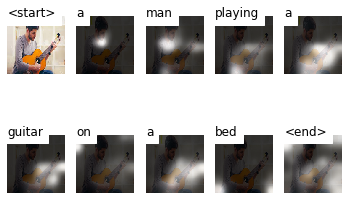

In [21]:
# Load model
checkpoint = torch.load("checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar", map_location="cpu")
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix) {"word1":0, "word2":1}
with open("WORDMAP_coco_5_cap_per_img_5_min_word_freq.json", 'r') as j:
    word_map = json.load(j)

### idx to word {0 : "word1", 1:"word2"}
rev_word_map = {v: k for k, v in word_map.items()}

image = "test_images/guitar.jpeg"
# image = "test_images/man_running.jpeg"

### alphas is nothing but attention weights
seq, alphas = caption_image(encoder, decoder, image, word_map, 5)
alphas = torch.FloatTensor(alphas)



# Visualize caption and attention of best sequence
visualize_att(image,#original image
              seq, #generated sequence
              alphas, #attention weights for every time steps
              rev_word_map # idx to word mapping
             )